In [1]:
import tensorflow as tf
from typing import Callable
import tensorflow_hub as hub
print(tf.__version__)
from typing import Callable

2.15.0


In [2]:
import numpy as np
from PIL import Image , ImageColor , ImageDraw , ImageFont ,ImageOps

In [3]:
import matplotlib.pyplot as plt
import time #for measuring  inference time

In [4]:
# ssd mobilenet version 2
module_handle: str = "https://tfhub.dev/google/openimages_v4/ssd/"
module_handle += "mobilenet_v2/1"

In [5]:
model = hub.load(module_handle)

In [21]:
detector: Callable = model.signatures['default']
print(detector)

ConcreteFunction Input Parameters:
Output Type:
  Dict[['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)], ['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)]]
Captures:
  None


In [7]:
model.signatures.keys()# all values are tensor objects

KeysView(_SignatureMap({'default': <ConcreteFunction () -> Dict[['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)], ['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)]] at 0x7CF72832E020>}))

In [8]:
detector = model.signatures['default']# choosing default signature for the model

In [9]:
def show_image(image:np.ndarray|Image.Image) -> None: #Displays an image inside the notebook.
  plt.figure(figsize= (20,15))
  plt.grid(False)
  plt.imshow(image)

In [10]:
import tempfile
import six
from six.moves.urllib.request import urlopen
from io import BytesIO

In [11]:
# Fetches an image online, resizes it and saves it locally.
def download_resize_image(url:str , new_width : int =256 , new_height : int = 256 , display : bool = True)-> str:
  _ , filename = tempfile.mkstemp(suffix = ".jpg") # creating a temporary file with ending jpg
  del _

  response = urlopen(url)# opening image url
  image_data = response.read()#reading image data
  image_data = BytesIO(image_data)#putting image data in memory buffer

  pil_image : Image.Image = Image.open(image_data)#opens image in the url
  pil_image = ImageOps.fit(pil_image , (new_width , new_height) , Image.ANTIALIAS) #resizing image , cropping if the asspect ratio is different
  pil_image_rgb: Image.Image = pil_image.convert("RGB")
  pil_image_rgb.save(filename , format = "JPEG" , quality = 90)
  print("Image downloaded to %s" %filename)
  if display :
    show_image(pil_image)

  return filename


<ipython-input-11-c1cf3c0604d0>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image , (new_width , new_height) , Image.ANTIALIAS) #resizing image , cropping if the asspect ratio is different


Image downloaded to /tmp/tmplzp__n5j.jpg


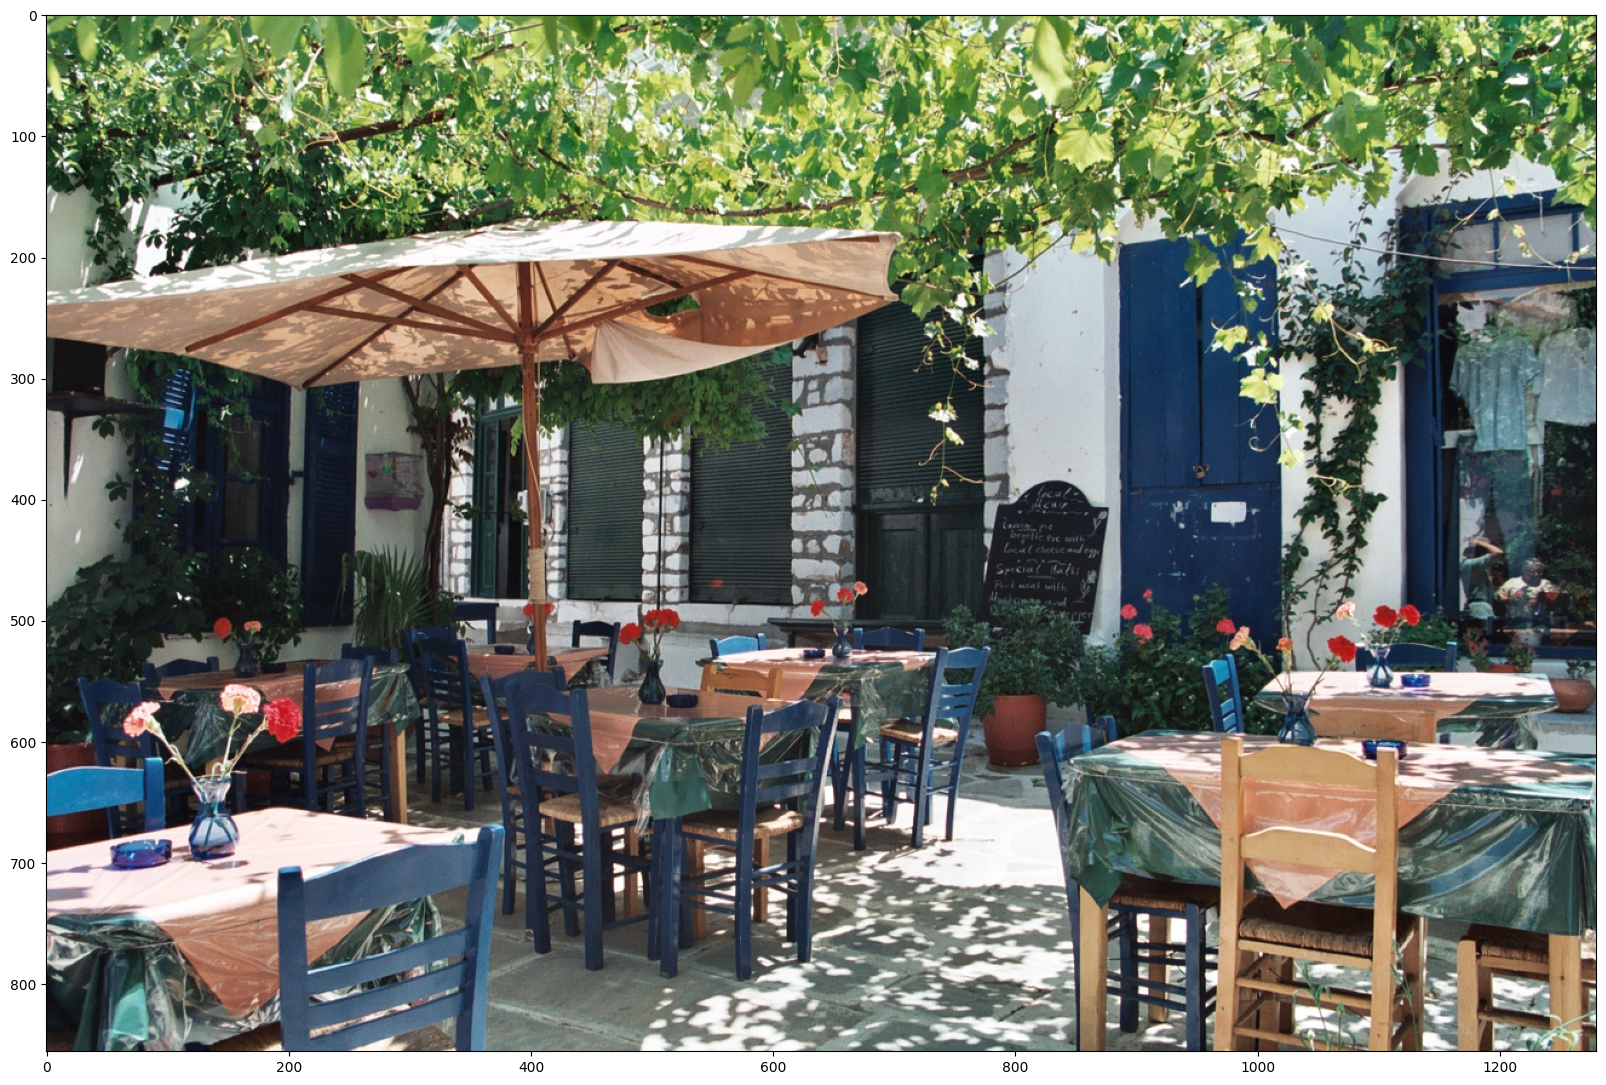

In [12]:
image_url: str = "https://upload.wikimedia.org/wikipedia/commons/6/60/"
image_url += "Naxos_Taverna.jpg"
downloaded_image_path: str = download_resize_image(
    image_url, 1280, 856, True
)

In [13]:
def draw_bounding_box(
    image: Image.Image,
    ymin: np.float32,
    xmin: np.float32,
    ymax: np.float32,
    xmax: np.float32,
    color:str  ,
    font: ImageFont.ImageFont ,
    thickness: int = 4 ,
    display_str_list: list = []
) -> None:
    draw : object = ImageDraw.Draw(image)
    im_width : int
    im_height : int
    im_width , im_height = image.size

    #scaling
    (left , right ,top , bottom)= (
        xmin*im_width , xmax*im_width , ymin*im_height , ymax*im_height
    )

    #edges of bounding box
    draw.line(
        [
            (left,top),
            (right , top),
            (right,bottom),
            (left,bottom),
            (left,top)
        ],
        width = thickness ,
        fill = color

    )

    #if combined height of the text exceeds visible area , it  needs to obe stacked eithin the boundary box
    display_str_heights: list = [
        font.getsize(ds)[1] for ds in display
    ]
     # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height: float = (1+(2*0.05))*sum(display_str_heights)

    if top > total_display_str_height:
      text_bottom : np.float32 = top
    else:
      text_bottom: top+total_display_str_height


      # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width: int
        text_height: int
        text_width, text_height = font.getsize(display_str)
        margin: np.ndarray = np.ceil(0.05 * text_height)
        draw.rectangle(   #draws a rectangle around the text.
            [
                (left, (text_bottom-text_height) - (2*margin)),
                (left + text_width, text_bottom)
            ],
            fill=color
        )
        #e draws the text within the rectangle. The position of the text is determined by the left margin (left + margin) and the vertical position ((text_bottom - text_height) - margin
        draw.text(
            (left + margin, (text_bottom-text_height) - margin),
            display_str,
            fill="black",
            font=font
        )
        text_bottom -= text_height - (2*margin)



In [35]:
#actually drawing bounding boxes
# def draw_boxes(
#     image: np.ndarray ,
#     boxes: np.ndarray ,
#     class_name : list ,
#     scores: np.ndarray ,
#     max_boxes : int = 10 ,
#     min_score = 0.1
# ) -> np.ndarray:
#     colors : list = list(ImageColor.colormap.values())

#     try:
#       font: ImageFont.ImageFont = ImageFont.truetype(("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-"
#              + "Regular.ttf"),
#              25
#        )
#     except IOError:
#       print("font not found , using default font .")
#       font = ImageFont.load_default()

#     for i in range(min(boxes.shape[0],max_boxes)):
#       if scores[i] >= min_score:
#         ymin: np.float32
#         xmin: np.float32
#         ymax: np.float32
#         xmax: np.float32
#         ymin  , xmin , ymax, xmax = tuple(boxes[i])
#         score: float = (100*scores[i])
#         display_str : str = f"{class_name[i].decode('ascii')}:{score}%"
#         color = colors[hash(class_name[i])%len(colors)]
#         image_pil: Image.Image = Image.fromarray(
#             np.uint8(image)
#         ).convert("RGB")


#         draw_bounding_box(
#             image_pil ,
#             ymin ,
#             xmin ,
#             ymax ,
#             xmax ,
#             color ,
#             font ,
#             display_str_list= [ display_str]

#         )
#         np.copyto(image , np.array(image_pil))

#     return image




In [45]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from typing import List

def draw_boxes(
    image: np.ndarray ,
    boxes: np.ndarray ,
    class_names: List[str] ,
    scores: np.ndarray ,
    max_boxes: int = 10 ,
    min_score: float = 0.1
) -> np.ndarray:
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            score = int(100 * scores[i])
            display_str = f"{class_names[i]}: {score}%"
            color = colors[hash(class_names[i]) % len(colors)]
            # Draw bounding box
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=3)
            # Draw label background
            text_width, text_height = draw.textsize(display_str, font=font)
            draw.rectangle([(xmin, ymin - text_height), (xmin + text_width, ymin)], fill=color)
            # Draw label
            draw.text((xmin, ymin - text_height), display_str, fill="black", font=font)

    return np.array(image_pil)


In [46]:
#take in the object detection model detector and the path to a sample image, then use this model to detect objects.
def load_img(path:str) -> tf.Tensor:
  img : tf.Tensor = tf.io.read_file(path)
#convert to a tensor
  img = tf.image.decode_jpeg(img , channels = 3)

  return img


In [47]:
import time

In [48]:
def run_detector(detector, path: str) -> None:
    '''
    Runs inference on a local file using an object detection model.

    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
    '''

    # load an image tensor from a local file path
    img: tf.Tensor = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img: tf.Tensor  = tf.image.convert_image_dtype(
        img, tf.float32
    )[tf.newaxis, ...]

    # run inference using the model
    start_time: float = time.time()
    result: dict = detector(converted_img)
    end_time: float = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # draw predicted boxes over the image
    image_with_boxes: np.ndarray = draw_boxes(
      img.numpy(),
      result["detection_boxes"],
      result["detection_class_entities"],
      result["detection_scores"]
    )

    # display the image
    show_image(image_with_boxes)


Found 100 objects.
Inference time:  0.1687312126159668


<ipython-input-45-03fc22478fa6>:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(display_str, font=font)
<ipython-input-45-03fc22478fa6>:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(display_str, font=font)
<ipython-input-45-03fc22478fa6>:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(display_str, font=font)
<ipython-input-45-03fc22478fa6>:33: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(display_str, font=font)
<ipython-input-45-03fc22478fa6>:33: DeprecationWarning: textsize is deprecated and will 

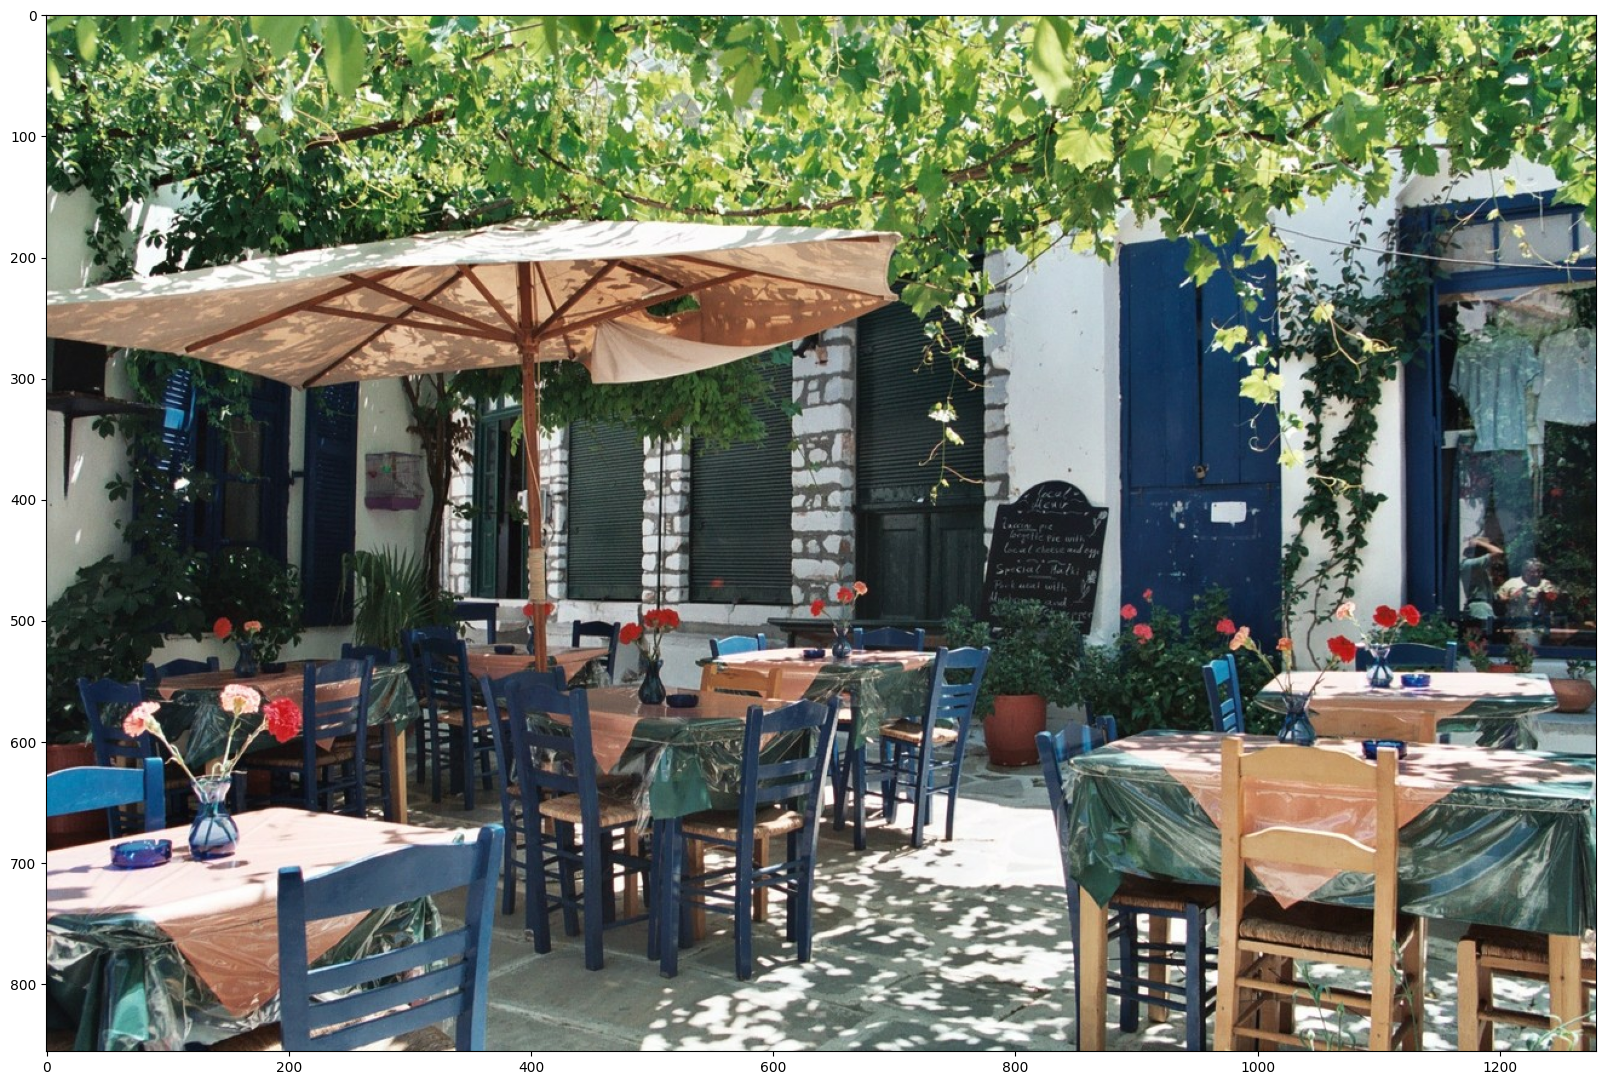

In [49]:
run_detector(detector , downloaded_image_path)